In [1]:
import torch
import torch as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
os.chdir("../models")
from common_utils import *
from gradmap_utils import *

# set seed
set_seed(42)

In [2]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])


# load data
test_dataset = CustomFlowers102(root='../data', split='train', download=True, transform=transform2)

# define dataloader to load single image
dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

In [3]:
# specify model path
model_path = 'saved_models/FinalModel/cuda/best_model.pt'
model_class = DepthPointWiseCNN()
# determine device type
if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")


# load model
model = cnn_grad_cam(model_class=model_class, model_path=model_path, device=device, last_conv_layer_idx=25)
model.eval()

# create directory to save grad maps
if not os.path.exists('../grad_maps/final'):
    os.makedirs('../grad_maps/final')

path = '../grad_maps/final'

# iterate over images in dataloader
for i, (img, label, img_path) in enumerate(dataloader):
    # get heatmap
    heatmap = get_heatmap(model, img)
    img_path = img_path[0]
    # resize image to larger size
    img = cv2.imread(img_path)
    # get filename of img_path
    filename = os.path.basename(img_path)

    # path to save grad map
    save_path = os.path.join(path, filename)

    # save grad_map
    save_grad_map(img, heatmap, save_path)
    
    if i == 9:
        break

In [4]:
# specify model path
model_path = 'saved_models/BaselineCNN/cuda/best_model.pt'
# define model class
model_class = BaselineCNN()
# determine device type
if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")


# load model
model = cnn_grad_cam(model_class=model_class, model_path=model_path, device=device, last_conv_layer_idx=15)
model.eval()

# create directory to save grad maps
if not os.path.exists('../grad_maps/baseline'):
    os.makedirs('../grad_maps/baseline')

path = '../grad_maps/baseline'

# iterate over images in dataloader
for i, (img, label, img_path) in enumerate(dataloader):
    # get heatmap
    heatmap = get_heatmap(model, img)
    img_path = img_path[0]
    # resize image to larger size
    img = cv2.imread(img_path)
    # get filename of img_path
    filename = os.path.basename(img_path)

    # path to save grad map
    save_path = os.path.join(path, filename)

    # save grad_map
    save_grad_map(img, heatmap, save_path)
    
    if i == 9:
        break

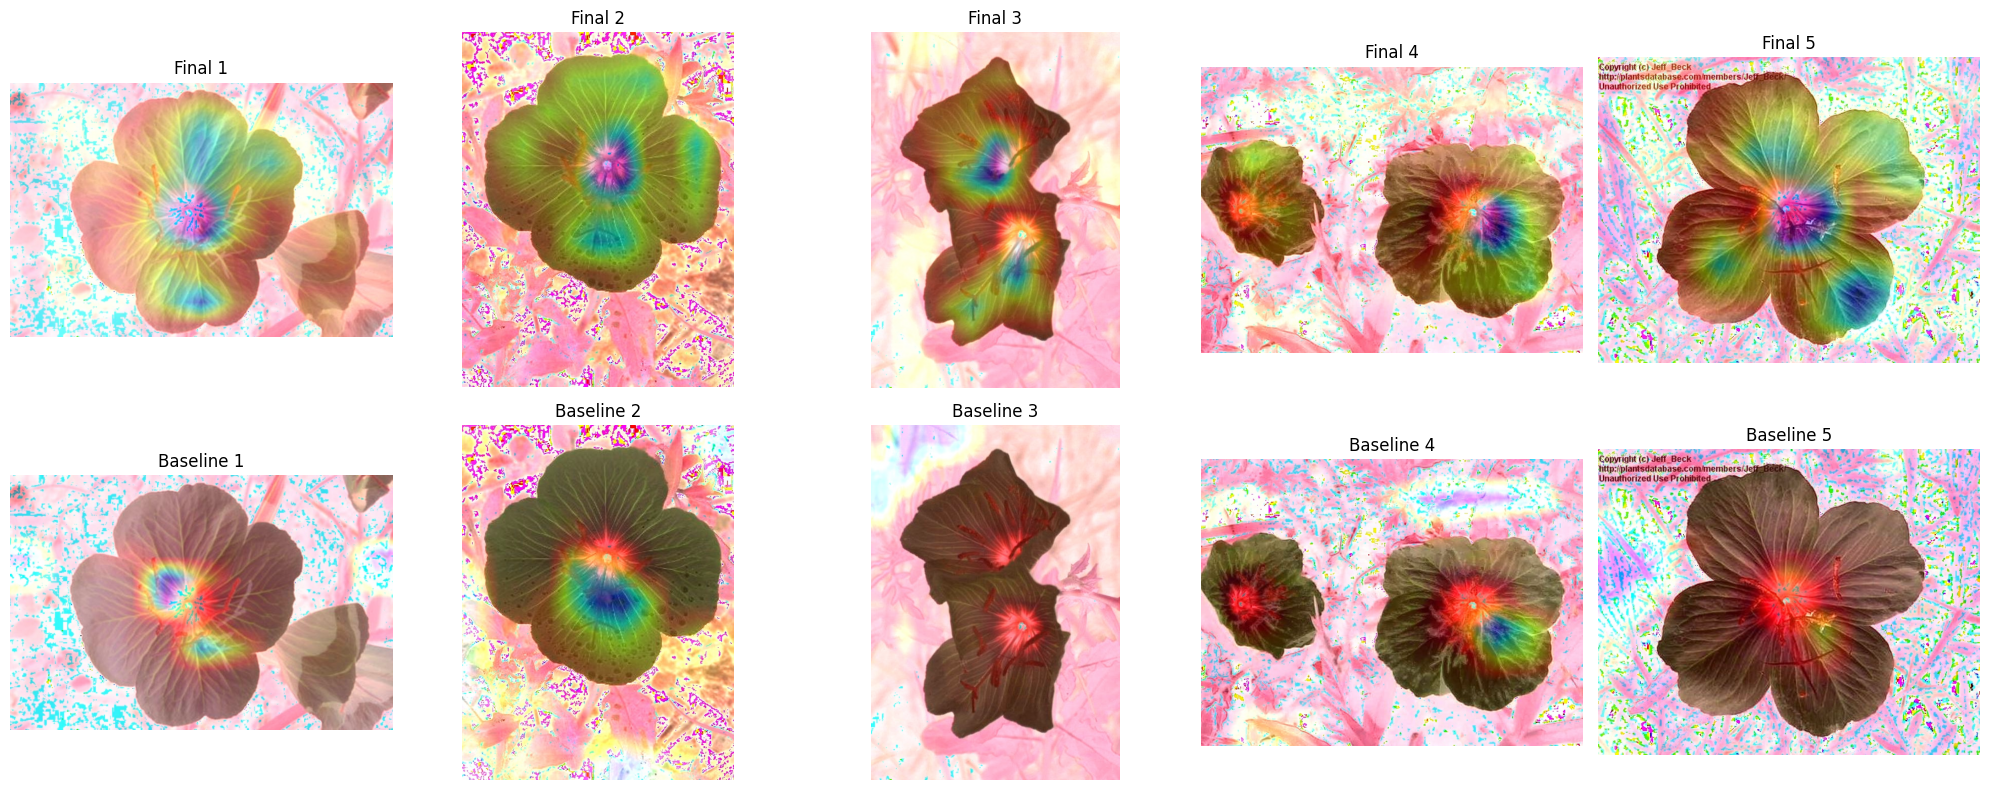

In [14]:
# specify path to baseline and final grad maps
baseline_path = '../grad_maps/baseline'
final_path = '../grad_maps/final'

# get list of filenames
baseline_filenames = os.listdir(baseline_path)
final_filenames = os.listdir(final_path)

# sort filenames
baseline_filenames.sort()
final_filenames.sort()

# how many pairs to show in one row
num_pairs = 5

# create figure with 2 rows and num_pairs columns
fig, axs = plt.subplots(2, num_pairs, figsize=(20, 8))  # Adjust the size as needed

# iterate over the first num_pairs filenames to show them in the first row
for i in range(num_pairs):
    # check if there are enough files
    if i < len(baseline_filenames) and i < len(final_filenames):
        # get baseline and final grad map
        baseline_grad_map = cv2.imread(os.path.join(baseline_path, baseline_filenames[i]))
        final_grad_map = cv2.imread(os.path.join(final_path, final_filenames[i]))

        # plot final grad maps in the top row
        axs[0, i].imshow(final_grad_map)
        axs[0, i].set_title(f'Final {i+1}')
        axs[0, i].axis('off')  # Hide axes

        # plot baseline grad maps in the bottom row
        axs[1, i].imshow(baseline_grad_map)
        axs[1, i].set_title(f'Baseline {i+1}')
        axs[1, i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()